In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Import Data

In [2]:
# Load the training dataset
df_train = pd.read_csv(r"C:\Users\ACER\Downloads\house-prices-advanced-regression-techniques\train.csv", index_col='Id')

# Drop unnecessary columns
df_train.drop(columns=['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], inplace=True)


In [3]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemodAdd 

# Splitting Data and Preprocessing

In [3]:
# Split into features and target
X = df_train.drop(columns='SalePrice')
y = df_train['SalePrice']

In [4]:
# Define numerical and categorical features
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

In [5]:
# Define preprocessing pipelines
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer([
    ('numeric', numerical_pipeline, numerical_features),
    ('categoric', categorical_pipeline, categorical_features)
])

# Modelling, Tuning, and Evaluation

In [6]:
# Define the XGBRegressor model pipeline
pipeline_xgb = Pipeline([
    ('prep', preprocessor),
    ('algo_xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
])

In [7]:
# Define the parameter grid for XGBRegressor
param_grid_xgb = {
    'algo_xgb__n_estimators': [100, 200],
    'algo_xgb__learning_rate': [0.05, 0.1],
    'algo_xgb__max_depth': [3, 5],
    'algo_xgb__min_child_weight': [1, 3],
    'algo_xgb__gamma': [0, 0.1],
    'algo_xgb__alpha': [0, 0.1, 1, 10],  # L1 Regularization
    'algo_xgb__lambda': [1, 2, 5, 10]   # L2 Regularization
}

# Define custom scoring (RMSE)
scoring = 'neg_root_mean_squared_error'

# Grid search for XGBRegressor
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid=param_grid_xgb, cv=3, scoring=scoring, n_jobs=-1, verbose=1)

# Fit the grid search object on training data
grid_search_xgb.fit(X, y)

# Print the best parameters and best RMSE score for XGBRegressor
print("Best parameters for XGBRegressor:", grid_search_xgb.best_params_)
print("Best RMSE score for XGBRegressor:", -grid_search_xgb.best_score_)

# Print R-squared score for XGBRegressor with best parameters
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_train = best_xgb_model.predict(X)
r2_xgb_train = r2_score(y, y_pred_train)
print("R^2 score for XGBRegressor on training data:", r2_xgb_train)

Fitting 3 folds for each of 512 candidates, totalling 1536 fits
Best parameters for XGBRegressor: {'algo_xgb__alpha': 0.1, 'algo_xgb__gamma': 0, 'algo_xgb__lambda': 10, 'algo_xgb__learning_rate': 0.1, 'algo_xgb__max_depth': 5, 'algo_xgb__min_child_weight': 1, 'algo_xgb__n_estimators': 200}
Best RMSE score for XGBRegressor: 26785.23880409128
R^2 score for XGBRegressor on training data: 0.9894520044326782


In [8]:
# Display actual vs predicted SalePrice for training data
results_train = pd.DataFrame({'Actual_SalePrice': y, 'Predicted_SalePrice': y_pred_train})
print("\nActual vs Predicted SalePrice for training data:")
print(results_train.head())


Actual vs Predicted SalePrice for training data:
    Actual_SalePrice  Predicted_SalePrice
Id                                       
1             208500        200526.234375
2             181500        175038.375000
3             223500        213689.109375
4             140000        151076.687500
5             250000        266002.906250


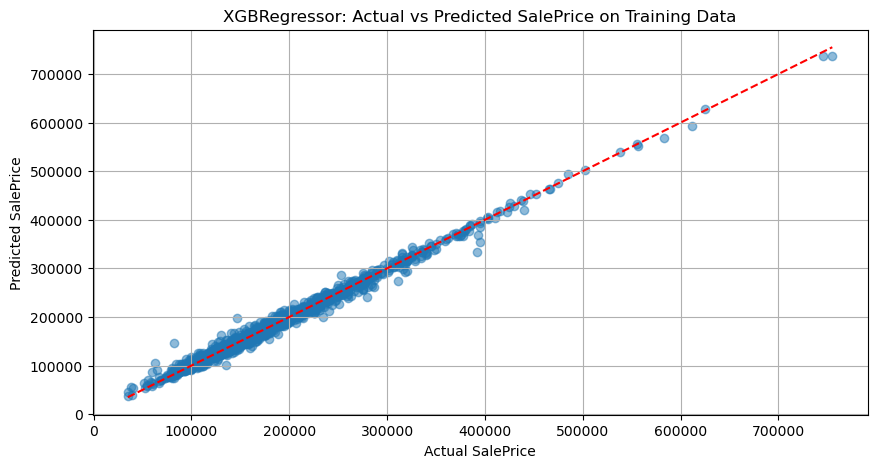

In [9]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for training set
plt.figure(figsize=(10, 5))
plt.scatter(y, y_pred_train, alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], '--', color='red')
plt.title("XGBRegressor: Actual vs Predicted SalePrice on Training Data")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.grid(True)
plt.show()

# Apply to New Dataset and Predict

In [10]:
# Load the test dataset
df_test = pd.read_csv(r"C:\Users\ACER\Downloads\house-prices-advanced-regression-techniques\test.csv", index_col='Id')  # Adjust path as per your test dataset location

In [11]:
# Preprocess the test dataset
X_test_new = grid_search_xgb.best_estimator_.named_steps['prep'].transform(df_test)

# Make predictions on the test dataset
predictions = grid_search_xgb.best_estimator_.named_steps['algo_xgb'].predict(X_test_new)


In [12]:
# Create a DataFrame with 'Id' and predicted 'SalePrice'
results_df = pd.DataFrame({
    'Id': df_test.index,
    'SalePrice': predictions
})

# Display the first few rows of the results
print("\nSample of 'Id' and 'SalePrice' columns from test dataset:")
print(results_df.head())


Sample of 'Id' and 'SalePrice' columns from test dataset:
     Id      SalePrice
0  1461  125369.429688
1  1462  155000.562500
2  1463  182293.890625
3  1464  192370.625000
4  1465  189375.515625


In [13]:
# Save the predictions to a CSV file
results_df.to_csv(r"C:\Users\ACER\Downloads\House Prices - Advanced Regression Techniques.csv", index=False)

print("Predictions saved to 'predictions.csv'.")


Predictions saved to 'predictions.csv'.
